# Menstrual Cycle Prediction Tool Using Age and BMI as Secondary Predictor Variables

Author: Kai Holl

**Helpful Links**

[Research Article](https://epublications.marquette.edu/cgi/viewcontent.cgi?article=1002&context=data_nfp)

[Dataset](https://epublications.marquette.edu/data_nfp/7/)

[Dataset (Kaggle)](https://www.kaggle.com/datasets/nikitabisht/menstrual-cycle-data/data)


The present analysis' primary goal is to create a menstrual cycle tracker that can be used to predict the day a user's next period will start based on information from their last three menstrual cycles.

The User's self-reported age and BMI will also be used as secondary predictor variables that will adjust the final prediction outputted by the model.

Previous research has indicated that age and BMI has a statistically significant relationship with menstrual cycle length, in that women in different age groups and BMI categories experience significant differences in cycle length. Thus, the model will adjust its final prediction based on this User-inputted information.

This will be achieved through the use of a machine learning model that will be trained using data from a study which collected the menstrual cycle and demographic information of a large nationally-representative sample of women.

User-inputted information will be piped into the final machine learning model in order to provide the user with a predicted start date of their next period.




# Importing required libraries

In [ ]:
import kagglehub
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pip
import seaborn as sns
import scipy
import shutil
import torch
import random

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

from datetime import datetime, date, timedelta

from google.colab import files

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


# Data Collection

The data used for this analysis comes from a 2013 study by [Fehring et al.](https://epublications.marquette.edu/cgi/viewcontent.cgi?article=1002&context=data_nfp) titled "Randomized comparison of two internet-supported natural family planning methods". This study collected data of the menstrual cycles of 159 anonymous American women over 12 months, with each woman having approximately 10 cycles logged. For each cycle, information such as the length of the cycle, the overall mean cycle length, estimated day of ovulation, length of menstruation, etc. is logged.

The dataset used for this study is freely-available to the public via Marquette University's e-Publications site (which can be accessed [here](https://epublications.marquette.edu/data_nfp/7/)) and is in .csv format.

I will now upload the dataset to the current session storage as a pandas DataFrame object and take a glimpse at it using the ```head()``` function.



In [ ]:
# import dataset
df = pd.read_csv("FedCycleData071012.csv")

df.head()

,ClientID,CycleNumber,Group,CycleWithPeakorNot,ReproductiveCategory,LengthofCycle,MeanCycleLength,EstimatedDayofOvulation,LengthofLutealPhase,FirstDayofHigh,...,Method,Prevmethod,Methoddate,Whychart,Nextpreg,NextpregM,Spousesame,SpousesameM,Timeattemptpreg,BMI
0,nfp8122,1,0,1,0,29,27.33,17,12,12,...,9,,,2,7,7,1,1,0,21.254724111867
1,nfp8122,2,0,1,0,27,,15,12,13,...,,,,,,,,,,
2,nfp8122,3,0,1,0,29,,15,14,,...,,,,,,,,,,
3,nfp8122,4,0,1,0,27,,15,12,13,...,,,,,,,,,,
4,nfp8122,5,0,1,0,28,,16,12,12,...,,,,,,,,,,


In [ ]:
df.shape

(1665, 80)

The current uncleaned dataframe has 1665 rows and 80 columns, with each row being a cycle for a single Client (study participant) and each column containing information about the cycle and the Client it belongs to.

In [ ]:
df.columns

Index(['ClientID', 'CycleNumber', 'Group', 'CycleWithPeakorNot',
       'ReproductiveCategory', 'LengthofCycle', 'MeanCycleLength',
       'EstimatedDayofOvulation', 'LengthofLutealPhase', 'FirstDayofHigh',
       'TotalNumberofHighDays', 'TotalHighPostPeak', 'TotalNumberofPeakDays',
       'TotalDaysofFertility', 'TotalFertilityFormula', 'LengthofMenses',
       'MeanMensesLength', 'MensesScoreDayOne', 'MensesScoreDayTwo',
       'MensesScoreDayThree', 'MensesScoreDayFour', 'MensesScoreDayFive',
       'MensesScoreDaySix', 'MensesScoreDaySeven', 'MensesScoreDayEight',
       'MensesScoreDayNine', 'MensesScoreDayTen', 'MensesScoreDay11',
       'MensesScoreDay12', 'MensesScoreDay13', 'MensesScoreDay14',
       'MensesScoreDay15', 'TotalMensesScore', 'MeanBleedingIntensity',
       'NumberofDaysofIntercourse', 'IntercourseInFertileWindow',
       'UnusualBleeding', 'PhasesBleeding', 'IntercourseDuringUnusBleed',
       'Age', 'AgeM', 'Maristatus', 'MaristatusM', 'Yearsmarried', 'Wedding

The current uncleaned DataFrame, ```df```, has some columns that contain information not needed for the present analysis, such as the Client's ethnicity, marital status, or intercouse information.

So, let's start by cleaning this dataset to make it fit for analysis.

# Cleaning the dataset

## Subsetting dataset columns

First, we are going to subset the dataset to only include the variables (columns) we are interested in.

Information about these columns is listed below.

In [ ]:
# specifying which columns of df we want to keep
clean_df = df[["ClientID", "CycleNumber", "LengthofCycle", "Age", "Height", "Weight", "BMI"]]

### Column information

**The following information on column information comes directly from Fehring et al.'s 2013 study, the data of which is being used for this analysis.**

**ClientID:** Randomized ID for client anonymity

- The inclusion criteria for female participants were that they needed to be between the age of 18 and 42 years, have a stated menstrual cycle length ranging between 21-42 days long, have no history of hormonal contraceptives for the past 3 months and, if post-breastfeeding, have experienced at least three cycles past weaning.

**CycleNumber:** study lasted 12-months for a potential total of 13 cycles tracked for each participant (one cycle approx. every month)

**LengthofCycle:** A menstrual cycle is defined as the time from the first day of a woman's period to the day before her next period.

- The length of the menstrual cycle varies from woman to woman, but the average is to have periods around every 28 days ([American College of Obstetrics and Gynecologists. The Menstrual Cycle: Menstruation, Ovulation, and How Pregnancy Occurs.](https://www.acog.org/womens-health/infographics/the-menstrual-cycle))

**Demographic Variables:**

- Age
- Height
- Weight
- BMI (calculated from Height & Weight)

In [ ]:
clean_df["ClientID"].nunique()

159

There are 159 unique Client IDs. Thus, the sample size for this DataFrame is 159 women between the ages of 18 and 42 years old.

In [ ]:
clean_df.shape

(1665, 7)

There are now 1,665 rows and 7 columns in our newly cleaned dataset.

## Changing class of variables

Let's change the variable classes for all of the columns other than "ClientID" to numeric so we can conduct descriptive statistics of them.

Let's first see the current variable types of all the columns within ```clean_df```.

In [ ]:
clean_df.dtypes

,0
ClientID,object
CycleNumber,int64
LengthofCycle,int64
Age,object
Height,object
Weight,object
BMI,object


Now, let's go ahead and convert all the columns besides ClientId to numeric.

In [ ]:
cols = ["LengthofCycle", "Age", "Height", "Weight", "BMI"]
clean_df[cols] = clean_df[cols].apply(pd.to_numeric, errors='coerce') # coerce cols to numeric

clean_df.dtypes # checking work

<ipython-input-9-a608e3a42431>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[cols] = clean_df[cols].apply(pd.to_numeric, errors='coerce') # coerce cols to numeric


,0
ClientID,object
CycleNumber,int64
LengthofCycle,int64
Age,float64
Height,float64
Weight,float64
BMI,float64


However, we don't want the "Age" column to be coded as float class. As you can see in the below input, the values of "Age" have decimal places at the end even though this is not necessary, since "Age" is almost always considered an integer variable.



In [ ]:
clean_df["Age"].unique()

array([36., nan, 39., 29., 26., 25., 23., 33., 30., 31., 24., 27., 35.,
       37., 32., 38., 21., 34., 22., 28., 43., 41., 40., 42.])

Let's use the ```.astype()``` function to convert "Age" to an "Int64" type.

In [ ]:
clean_df["Age"] = clean_df["Age"].astype('Int64')

<ipython-input-11-d3ed285a67a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["Age"] = clean_df["Age"].astype('Int64')


In [ ]:
clean_df["Age"].unique() # checking work

<IntegerArray>
[  36, <NA>,   39,   29,   26,   25,   23,   33,   30,   31,   24,   27,   35,
   37,   32,   38,   21,   34,   22,   28,   43,   41,   40,   42]
Length: 24, dtype: Int64

There we go, now all of the variables in our dataset are the right variable types!

## Changing empty values to nan

Now, let's see what unique values exist for all of the variables within our clean_df DataFrame.

In [ ]:
for cols in clean_df.columns:
    print(f"{cols} : \n {clean_df[cols].unique()} \n \n")

ClientID : 
 ['nfp8122' 'nfp8114' 'nfp8109' 'nfp8107' 'nfp8106' 'nfp8024' 'nfp8020'
 'nfp8026' 'nfp8030' 'nfp8031' 'nfp8032' 'nfp8034' 'nfp8036' 'nfp8040'
 'nfp8041' 'nfp8042' 'nfp8043' 'nfp8045' 'nfp8046' 'nfp8047' 'nfp8049'
 'nfp8050' 'nfp8051' 'nfp8057' 'nfp8058' 'nfp8060' 'nfp8062' 'nfp8063'
 'nfp8064' 'nfp8066' 'nfp8068' 'nfp8069' 'nfp8072' 'nfp8073' 'nfp8074'
 'nfp8076' 'nfp8079' 'nfp8080' 'nfp8083' 'nfp8085' 'nfp8087' 'nfp8091'
 'nfp8094' 'nfp8099' 'nfp8100' 'nfp8101' 'nfp8102' 'nfp8110' 'nfp8113'
 'nfp8116' 'nfp8123' 'nfp8124' 'nfp8129' 'nfp8131' 'nfp8133' 'nfp8137'
 'nfp8140' 'nfp8143' 'nfp8144' 'nfp8149' 'nfp8150' 'nfp8152' 'nfp8154'
 'nfp8155' 'nfp8159' 'nfp8161' 'nfp8164' 'nfp8165' 'nfp8168' 'nfp8172'
 'nfp8173' 'nfp8174' 'nfp8176' 'nfp8177' 'nfp8178' 'nfp8179' 'nfp8184'
 'nfp8186' 'nfp8187' 'nfp8188' 'nfp8189' 'nfp8190' 'nfp8192' 'nfp8193'
 'nfp8195' 'nfp8196' 'nfp8197' 'nfp8200' 'nfp8206' 'nfp8207' 'nfp8209'
 'nfp8210' 'nfp8211' 'nfp8212' 'nfp8218' 'nfp8221' 'nfp8223' 'nf

It looks like we have quite a few missing values in the variables of our clean_df DataFrame.

Let's find the **number** of missing values in all the columns.

In [ ]:
clean_df.isnull().sum()

,0
ClientID,0
CycleNumber,0
LengthofCycle,0
Age,1523
Height,1532
Weight,1531
BMI,1534


This output is helpful, but it is hard to tell how many of the 7 columns in our dataset have missing values compared to how many that do not.

Thus, it would be even more helpful for us to write a function whose output will be a list of the columns with missing values and a list of the columns without.

In [ ]:
# create an empty container for columns with missing values
missing_cols = []
# create an empty container for columns *without* missing values
no_missing_cols = []

# create a for loop
for cols in clean_df.columns:
    if clean_df[cols].isnull().sum() == 0:
        no_missing_cols.append(cols) # if sum of missing values is 0, add column name to no_missing_cols
    else: # if sum of missing values if not 0
        missing_cols.append(cols) # if sum of missing values is not 0, add column name to missing_cols

# print(missing_cols)
# print(no_missing_cols)

# names of columns
print("Columns WITH missing values: ", missing_cols)
print("Columns without any missing values: ", no_missing_cols)

Columns WITH missing values:  ['Age', 'Height', 'Weight', 'BMI']
Columns without any missing values:  ['ClientID', 'CycleNumber', 'LengthofCycle']


So, that's 4 columns with missing values and 3 columns without missing values.

However, it makes sense that the demographic columns ("Age", "Height", "Weight", "BMI) have missing values, since there is only one of these values for each Client in the dataset. That is to say, when the first row (ie., cycle) of a Client appears, this information for said Client is logged in that row, but for all subsequent cycles (rows) of that same Client, this information is left blank.  

Because of this, we only really need to worry about how many missing values are in these columns in our final dataframe which will be used to train the predictive model. We will return to this concern once this final dataframe has been created.

### Demographics

Let's see if we can first reduce the number of missing values in the demographic columns.

As you can see in the above output, despite the fact that BMI is calculated from Height and Weight, there is slightly more missing BMI values (1534) than in either the Height (1532) or Weight (1531) columns.

So, let's write some code that will calculate the BMI for each Client to ensure that any missing BMI values will be filled.

Since the values of the "Height" and "Weight" columns are in the US customary units (pounds (lbs) and inches), we can calculate BMI for each row using the following formula:

**US customary units: BMI = weight (pounds) / [height (in)]^2 x 703**

Source: [CDC, What Is Body Mass Index (BMI)?](https://www.cdc.gov/growth-chart-training/hcp/using-bmi/body-mass-index.html)

Written in code, that formula looks like this:

In [ ]:
clean_df["BMI"] = round((clean_df["Weight"] / (clean_df["Height"] ** 2) * 703), 2)

<ipython-input-16-c28fb898d135>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["BMI"] = round((clean_df["Weight"] / (clean_df["Height"] ** 2) * 703), 2)


In [ ]:
clean_df.isnull().sum()

,0
ClientID,0
CycleNumber,0
LengthofCycle,0
Age,1523
Height,1532
Weight,1531
BMI,1532


After calculating BMI for each row, it now looks like the "BMI" column only has 1532 missing values instead of 1534! So, we filled in the BMI information for 2 rows in the clean_df DataFrame.

Now that the "BMI" column is as complete as possible, we can go ahead and remove the "Height" and "Weight" columns from the clean_df DataFrame, as they are no longer of any use to us.

In [ ]:
clean_df = clean_df.drop(["Height", "Weight"], axis = 1)
# axis 0 = rows, axis 1 = columns

# checking work
clean_df.columns

Index(['ClientID', 'CycleNumber', 'LengthofCycle', 'Age', 'BMI'], dtype='object')

In [ ]:
clean_df.shape

(1665, 5)

Our clean_df DataFrame now has 1,665 rows and 5 columns!

# Grouping CycleNumber columns by threes

As mentioned in the beginning of this analysis, the goal is to create a menstrual cycle tracker that can be used to predict the day a user's next period will start based on information from their last two menstrual cycles.

Therefore, in order to train the model that will make these predictions, we need to find a way to extract 3 cycles from the same Client and convert these into columns in a new DataFrame.

Since some Clients had a larger number of reported cycle lengths than others, the number of times each Client will be repeated as a row in the new DataFrame will vary. However, each of these "triplets" will only come from a single Client to ensure that the model is accurately predicting menstrual cycle length using a single person as each sample.

These "triplets" will have overlap to create a larger training and testing set to use with our model. To illustrate, here is a visual example:

Cycle 1, Cycle 2, Cycle 3 = one triplet

Cycle 2, Cyle 3, Cycle 4 = one triplet

Cycle 3, Cycle 4, Cycle 5 = one triplet

Cycle 4, Cycle 5, Cycle 6 = one triplet


In order to pivot our clean_df DataFrame into a new DataFrame wherein every row is a single client (ClientID) and there are columns for every CycleLength that make up a "triplet", we need to first create a new column within clean_df, ClientCycleID, which contains a unique identifier for each row. This will allow us to use ClientID as the index in our ```clean_df.pivot_table()``` function.

Each value within the newly created column "ClientCycleID" is a combination of that row's "ClientID" and "CycleNumber" values, written as a string value.

In [ ]:
# create a new column "ClientCycleID" by combining "ClientID" and "CycleNumber"
clean_df["ClientCycleID"] = clean_df["ClientID"].astype(str) + "_" + clean_df["CycleNumber"].astype(str)

# shift newly created "ClientCycleID" column to front of clean_df DataFrame
# -----------------------------------------
first_column = clean_df.pop("ClientCycleID")
# insert column using insert(position,column_name, first_column) function
clean_df.insert(0, "ClientCycleID", first_column)

clean_df

,ClientCycleID,ClientID,CycleNumber,LengthofCycle,Age,BMI
0,nfp8122_1,nfp8122,1,29,36,21.25
1,nfp8122_2,nfp8122,2,27,<NA>,NaN
2,nfp8122_3,nfp8122,3,29,<NA>,NaN
3,nfp8122_4,nfp8122,4,27,<NA>,NaN
4,nfp8122_5,nfp8122,5,28,<NA>,NaN
...,...,...,...,...,...,...
1660,nfp8334_7,nfp8334,7,29,<NA>,NaN
1661,nfp8334_8,nfp8334,8,28,<NA>,NaN
1662,nfp8334_9,nfp8334,9,28,<NA>,NaN
1663,nfp8334_10,nfp8334,10,40,<NA>,NaN


Now we can create that new DataFrame mentioned previously, where every row is a single ClientID and there is a column for every triplet.

In [ ]:
# get all the unique client ids
unique_client_ids = set(clean_df['ClientID'])

# create a new dataframe where we will store everything
new_df = pd.DataFrame({'ClientID' : [], 'Cycle_1' : [], 'Cycle_2' : [], 'Cycle_3' : []})

# loop through client ids
for client_id in unique_client_ids:
    # only take the portion of clean_df that belong to this client
    t1 = clean_df[clean_df['ClientID'] == client_id]
    # only take these two columns
    t1 = t1[['ClientID', 'LengthofCycle']]

    # loop through all the rows except last two
    for i in range(t1.shape[0]-2):
        # for every row, get that row and the two rows after that
        t2 = t1.iloc[i:(i+3)].copy()
        # create a new column
        t2['CycleID'] = ['Cycle_1', 'Cycle_2', 'Cycle_3']
        # reshape
        t3 = t2.pivot(index = 'ClientID', columns = 'CycleID', values = 'LengthofCycle')
        # add to the dataframe
        new_df = pd.concat([new_df, t3.reset_index()], axis = 0)

# check out
new_df

,ClientID,Cycle_1,Cycle_2,Cycle_3
0,nfp8260,34.0,33.0,31.0
0,nfp8260,33.0,31.0,30.0
0,nfp8260,31.0,30.0,33.0
0,nfp8260,30.0,33.0,34.0
0,nfp8260,33.0,34.0,30.0
...,...,...,...,...
0,nfp8168,29.0,24.0,26.0
0,nfp8168,24.0,26.0,24.0
0,nfp8168,26.0,24.0,25.0
0,nfp8168,24.0,25.0,29.0


In [ ]:
new_df.shape

(1358, 4)

Our new DataFrame, new_df, which contains the triplet CycleLengths, has 1,358 rows and 4 columns.

## Adding secondary predictor variables

Since we want to use the demographic variables Age and BMI as secondary variables for menstrual cycle prediction, let's create a new DataFrame, dems, which contains only the ClientID and predictor variable columns of clean_df. We will need to preserve the ClientID column to use as a key during merging.

During the creation of this dems DataFrame, we will drop rows where both "Age" and "bMI" have missing values, since, as mentioned previously, age and BMI information is only listed in a single row for each Client. This will ensure that only one row exists for each Client.




In [ ]:
dems = clean_df[["ClientID", "Age", "BMI"]]

# convert to pandas DataFrame
dems = dems.reset_index()

# Drop rows where both 'Age' and 'BMI' are missing
dems = dems.dropna(subset=['Age', 'BMI'], how='all')

# checking work
# --------------
# dems.head()
# dems.shape # 1665, 4

dems

,index,ClientID,Age,BMI
0,0,nfp8122,36,21.25
45,45,nfp8114,39,28.13
47,47,nfp8109,29,29.05
50,50,nfp8107,26,NaN
58,58,nfp8106,25,27.89
...,...,...,...,...
1345,1345,nfp8288,30,27.98
1348,1348,nfp8289,40,22.46
1380,1380,nfp8290,33,NaN
1393,1393,nfp8292,34,24.21


Now, let's merge dems and new_df together into a single DataFrame.

We will be using a left merge in order to keep every row of new_df and discard any rows in dems that do not have a matching ClientID in new_df.

This new dataframe will contain the menstrual cycle triplets and secondary predictor variables of each client.

In [ ]:
final_df = new_df.merge(dems, on = ["ClientID"], how = "left")

final_df

,ClientID,Cycle_1,Cycle_2,Cycle_3,index,Age,BMI
0,nfp8260,34.0,33.0,31.0,1183.0,25,26.62
1,nfp8260,33.0,31.0,30.0,1183.0,25,26.62
2,nfp8260,31.0,30.0,33.0,1183.0,25,26.62
3,nfp8260,30.0,33.0,34.0,1183.0,25,26.62
4,nfp8260,33.0,34.0,30.0,1183.0,25,26.62
...,...,...,...,...,...,...,...
1377,nfp8168,29.0,24.0,26.0,754.0,36,24.36
1378,nfp8168,24.0,26.0,24.0,754.0,36,24.36
1379,nfp8168,26.0,24.0,25.0,754.0,36,24.36
1380,nfp8168,24.0,25.0,29.0,754.0,36,24.36


I will also go ahead and drop the "index" column that was created from the merge, as it is not necessary for analysis.


In [ ]:
final_df = final_df.drop(["index"], axis = 1)

final_df

,ClientID,Cycle_1,Cycle_2,Cycle_3,Age,BMI
0,nfp8260,34.0,33.0,31.0,25,26.62
1,nfp8260,33.0,31.0,30.0,25,26.62
2,nfp8260,31.0,30.0,33.0,25,26.62
3,nfp8260,30.0,33.0,34.0,25,26.62
4,nfp8260,33.0,34.0,30.0,25,26.62
...,...,...,...,...,...,...
1377,nfp8168,29.0,24.0,26.0,36,24.36
1378,nfp8168,24.0,26.0,24.0,36,24.36
1379,nfp8168,26.0,24.0,25.0,36,24.36
1380,nfp8168,24.0,25.0,29.0,36,24.36


Thus, our final dataset that will be used for analysis, final_df, has 1,382 rows and 6 columns.

## Cleaning the final dataset

It was mentioned previously that it made sense that the demographic variables "Age" and "BMI" had missing values in the clean_df DataFrame, since each Client had several rows, with each row representing a cycle.

However, now that we have our final dataset, final_df, where the demographic information for each Client is repeated each time a triplet is used from that Client, let's look at the proportion of missing values within these variables.

In [ ]:
null = final_df[["BMI", "Age"]].isnull().sum().sort_values(ascending=False)
null_per = ((final_df[["BMI", "Age"]].isnull().sum()) / (final_df.shape[0])).sort_values(ascending=False)*100.
null_values = pd.DataFrame({
    "Column Name": null.index,
    "Total Number of Missing Values": null.values,
    "Missing Values in Percentage": null_per.values
})

null_values

,Column Name,Total Number of Missing Values,Missing Values in Percentage
0,BMI,296,21.418234
1,Age,225,16.280753


It looks like the "BMI" variable has 296 missing values at around 21.42% of the dataset and the variable "Age" has 225 missing values at around 16.28% of the dataset.

These proportions are slightly cause for concern, as they may lead to some issues with the predictive ability of our model when we use them as predictor variables.

We will have to create a model that includes these demographic variables and one that does not and compare their predictive ability in order to see how much of an effect these missing values truly have.

### Adding a mean cycle length column

In order to conduct further analysis, we will need to have a single column that represents cycle length for each row. By doing so, we will be able to use said column to analyse how our predictor variables relate to cycle length.

So, let's create a new variable in final_df called "Mean_Length" that takes the mean cycle length of each row.

In [ ]:
final_df["Mean_Length"] = round(final_df[["Cycle_1", "Cycle_2", "Cycle_3"]].mean(axis = 1), 1)

final_df

,ClientID,Cycle_1,Cycle_2,Cycle_3,Age,BMI,Mean_Length
0,nfp8260,34.0,33.0,31.0,25,26.62,32.7
1,nfp8260,33.0,31.0,30.0,25,26.62,31.3
2,nfp8260,31.0,30.0,33.0,25,26.62,31.3
3,nfp8260,30.0,33.0,34.0,25,26.62,32.3
4,nfp8260,33.0,34.0,30.0,25,26.62,32.3
...,...,...,...,...,...,...,...
1377,nfp8168,29.0,24.0,26.0,36,24.36,26.3
1378,nfp8168,24.0,26.0,24.0,36,24.36,24.7
1379,nfp8168,26.0,24.0,25.0,36,24.36,25.0
1380,nfp8168,24.0,25.0,29.0,36,24.36,26.0


### BMI

In order to conduct more clear and concise data visualization and analysis, we should create nominal categories for the Age and BMI variables.


**BMI Categories**

Based on categorization by the Centers for Disease Control and Prevention (CDC), BMI scores for adults 20 years and older fall into the following categories:

**BMI Category ------- BMI Range**
- Underweight: less than 18.5
- Healthy Weight: 18.5 to less than 25
- Overweight: 25 to less than 30
- Obesity: 30 or greater


Source: [CDC, Adult BMI Categories](https://www.cdc.gov/bmi/adult-calculator/bmi-categories.html)




Given these categories, let's create a new column called "BMI_Cat" that contains the BMI category for each Client, written as a string value.

We will achieve this by writing a function to categorize the BMI scores into categories, and then applying it to the final_df dataset.

In [ ]:
def bmi_category(BMI):
    if BMI < 18.5:
        return "Underweight"
    elif 18.5 <= BMI < 25:
        return "Healthy Weight"
    elif 25 <= BMI < 30:
        return "Overweight"
    elif BMI >= 30:
        return "Obese"
    else:
        pass

# apply newly created bmi_category function to "BMI" column
final_df["BMI_Cat"] = final_df["BMI"].apply(bmi_category) # create new column BMI_Cat using function

final_df.dropna(subset = ["BMI_Cat", "BMI"], how = "all", inplace = False) # see BMI_Cat column in below output

,ClientID,Cycle_1,Cycle_2,Cycle_3,Age,BMI,Mean_Length,BMI_Cat
0,nfp8260,34.0,33.0,31.0,25,26.62,32.7,Overweight
1,nfp8260,33.0,31.0,30.0,25,26.62,31.3,Overweight
2,nfp8260,31.0,30.0,33.0,25,26.62,31.3,Overweight
3,nfp8260,30.0,33.0,34.0,25,26.62,32.3,Overweight
4,nfp8260,33.0,34.0,30.0,25,26.62,32.3,Overweight
...,...,...,...,...,...,...,...,...
1377,nfp8168,29.0,24.0,26.0,36,24.36,26.3,Healthy Weight
1378,nfp8168,24.0,26.0,24.0,36,24.36,24.7,Healthy Weight
1379,nfp8168,26.0,24.0,25.0,36,24.36,25.0,Healthy Weight
1380,nfp8168,24.0,25.0,29.0,36,24.36,26.0,Healthy Weight


In [ ]:
# checking work
# -------------
final_df["BMI_Cat"].unique() # 107
# final_df["BMI_Cat"].isnull().sum() # 1532

array(['Overweight', None, 'Healthy Weight', 'Obese', 'Underweight'],
      dtype=object)

### Age


Since age is also a numeric variable, let's create a new column that contains age categories like we did for BMI.

Let's use the age ranges that are mentioned in research that looks at differences in menstrual cycle length by age ([Harvard T.H. Chan School of Public Health, Menstrual cycles today](https://hsph.harvard.edu/research/apple-womens-health-study/study-updates/menstrual-cycles-today-how-menstrual-cycles-vary-by-age-weight-race-and-ethnicity/)) as the grouping method.

In [ ]:
def age_category(Age):
    if Age < 20:
        return "Under 20"
    elif 20 <= Age <= 24:
        return "20-24"
    elif 25 <= Age <= 29:
        return "25-29"
    elif 30 <= Age <= 34:
        return "30-34"
    elif 35 <= Age <= 39:
        return "35-39"
    elif 40 <= Age <= 44:
        return "40-44"
    elif 45 <= Age <= 49:
        return "45-49"
    elif Age >= 50:
        return "50+"
    else:
        pass

# applies newly created age_category function to "Age" column
final_df["Age_Cat"] = final_df["Age"].apply(age_category) # creates new "Age_Cat" column using function

final_df.dropna(subset = ["Age_Cat", "Age"], how = "all", inplace = False) # see Age_Cat column in below output

,ClientID,Cycle_1,Cycle_2,Cycle_3,Age,BMI,Mean_Length,BMI_Cat,Age_Cat
0,nfp8260,34.0,33.0,31.0,25,26.62,32.7,Overweight,25-29
1,nfp8260,33.0,31.0,30.0,25,26.62,31.3,Overweight,25-29
2,nfp8260,31.0,30.0,33.0,25,26.62,31.3,Overweight,25-29
3,nfp8260,30.0,33.0,34.0,25,26.62,32.3,Overweight,25-29
4,nfp8260,33.0,34.0,30.0,25,26.62,32.3,Overweight,25-29
...,...,...,...,...,...,...,...,...,...
1377,nfp8168,29.0,24.0,26.0,36,24.36,26.3,Healthy Weight,35-39
1378,nfp8168,24.0,26.0,24.0,36,24.36,24.7,Healthy Weight,35-39
1379,nfp8168,26.0,24.0,25.0,36,24.36,25.0,Healthy Weight,35-39
1380,nfp8168,24.0,25.0,29.0,36,24.36,26.0,Healthy Weight,35-39


# Descriptive statistics

Now, let's conduct some basic descriptive statistics of our key variables to get a better sense of the dataset we are going to use to build our final model.

## Menstrual Cycle Length

In [ ]:
print("The average menstrual cycle length of the entire sample is", round(final_df["Mean_Length"].mean(), 2), "days.")

The average menstrual cycle length of the entire sample is 29.15 days.


Compared to the aforementioned information reported by the American College of Obstetrics and Gynecologists that found the average menstrual cycle to be around 28 days long, the current sample's average is slightly higher, at about 1.15 days longer.

This is not a substantial enough difference to warrant concern, and is likely due to natural deviations from the mean.

In [ ]:
print("The shortest menstrual cycle length in the dataset is", final_df['Mean_Length'].min())
print("The longest menstrual cycle length in the dataset is", final_df['Mean_Length'].max())

The shortest menstrual cycle length in the dataset is 22.3
The longest menstrual cycle length in the dataset is 45.3


The range of menstrual cycle lengths in the dataset is 22.3 days long at its shortest and 45.3 days long at its longest.

Given that inclusion criteria for the pariticipants in the study was that they had to have a stated menstrual cycle length ranging between 21 and 42 days long, these values fall approximately within that range.

## Demographic Variables

### BMI

There appears to be a correlation between BMI and one's menstrual cycle length.

A 2022 meta-analysis of the effects of obesity on the menstrual cycle found that women with higher BMIs tend to have longer menstrual cycles. For instance, women with obesity (BMI ≥ 30) have an average cycle length of 29.4 days, compared to 28.9 days for women with a healthy BMI (18.5-24.9).

Source: [Itriyeva, K. (2022). The effects of obesity on the menstrual cycle.](https://pmc.ncbi.nlm.nih.gov/articles/PMC9449629/#:~:text=Specifically%2C%20women%20with%20obesity%20(BMI,(greater%20than%2035%20days)


First, let's take a look at the descriptive statistics of the BMI variable of our dataset.

In [ ]:
final_df["BMI"].nunique()

90

In [ ]:
print("The lowest BMI score in the dataset is", final_df['BMI'].min())
print("The highest BMI score in the dataset is", final_df['BMI'].max())

The lowest BMI score in the dataset is 18.01
The highest BMI score in the dataset is 49.92


There are 90 unique BMI scores in the final_df DataFrame, with scores ranging from 18.01 at the lowest to 49.92 at the highest. Given the BMI categories, our dataset reflects the full range of categories possible.


Now, let's find the average menstrual cycle length grouped by BMI Category to see if the current dataset reflects previous findings.

In [ ]:
# find average menstrual cycle length grouped by BMI category
# -----------------------------------------------------------
menst_BMI = round(final_df.groupby('BMI_Cat')["Mean_Length"].mean(), 2).sort_values(ascending = True)

print(menst_BMI)

BMI_Cat
Healthy Weight    28.91
Overweight        28.92
Obese             29.67
Underweight       29.70
Name: Mean_Length, dtype: float64


Based on these results, it looks like women in the "Underweight" category experienced the longest cycles on average, followed by "Obese" and "Overweight" women.

This appears to contradict past research that found that women with higher BMIs tend to have longer menstrual cycles.

However, if we look at the value counts for each BMI category in our dataset, we can see that there is only a single row in final_df that has the BMI category of "Underweight".

In [ ]:
final_df['BMI_Cat'].value_counts()

,count
BMI_Cat,
Healthy Weight,591
Overweight,347
Obese,147
Underweight,1


In [ ]:
final_df[final_df["BMI_Cat"] == "Underweight"]

,ClientID,Cycle_1,Cycle_2,Cycle_3,Age,BMI,Mean_Length,BMI_Cat,Age_Cat
729,nfp8063,27.0,33.0,29.0,23,18.01,29.7,Underweight,20-24


This row, outputted above, is what is causing our dataset to appear as though underweight women have longer cycle lengths that other women in the dataset.

Given that there is only one underweight woman in our dataset, she cannot stand to represent all underweight women in the population. It is very possible that her slightly longer than BMI is a fluke, and we cannot calculate averages from a single value.

Thus, it would be prudent to remove this Client from the dataset entirely to prevent further confusion.

In [ ]:
# remove rows where column 'ClientID' has the value 'nfp8063'
final_df = final_df[final_df['ClientID'] != 'nfp8063']

Now let's look at at the average menstrual cycle length grouped by BMI Category again.

In [ ]:
menst_BMI = round(final_df.groupby('BMI_Cat')["Mean_Length"].mean(), 2).sort_values(ascending = True)

print(menst_BMI)

BMI_Cat
Healthy Weight    28.91
Overweight        28.92
Obese             29.67
Name: Mean_Length, dtype: float64


After cleaning our dataset, it appears as though the current sample does reflect previous findings that women with higher BMIs tend to have longer menstrual cycles, though the difference is not very substantial.

Additionally, obese women in the current dataset had an average cycle length of 29.67 days, which is significantly close to Itriyeva's (2022) findings of 29.4 days for their sample of obese women. Their sample of healthy weight women had an average cycle length of 28.9 days, which is also almost exactly the same found in the current sample.

Given the small difference between the categories, additional analysis is definitely needed to determine if this difference is statistically significant.

### Age

Menstrual cycle length has to been found to differ notably with age throughout the reproductive lifespan.

Specifically, until women are 50 years or older, the lengths of their menstrual cycles tends to shorten on average.

People under 20 years old had menstrual cycles 30.3 days long on average, 1.6 days longer than the 28.7-day average for those 35 to 39 years old.

Additionally, people 40-44 and 45-49 years old had shorter cycles, averaging 28.2 and 28.4 days, respectively.

Those over 50 years old had longer cycles, averaging 30.8 days.

Source: [Harvard T.H. Chan School of Public Health, Menstrual cycles today](https://hsph.harvard.edu/research/apple-womens-health-study/study-updates/menstrual-cycles-today-how-menstrual-cycles-vary-by-age-weight-race-and-ethnicity/)

Let's first look at the distribution of ages in our dataset.

In [ ]:
final_df["Age"].count()

1156

In [ ]:
print("The youngest age in the dataset is", final_df['Age'].min(), "years old")
print("The oldest age in the dataset is", final_df['Age'].max(), "years old")

The youngest age in the dataset is 21 years old
The oldest age in the dataset is 43 years old


There are 1,156 values in the "Age" column of clean_df, with the ages of women in the dataset varying from 21 years old at the youngest to 43 years old at the oldest.

Given that we do not have any Clients in our dataset that are over 50 years old, we should expect that the older the Client is, the *shorter* their cycle will be on average.

Since research found that the average cycle length among women aged 35-39 years old was 28.7 days versus between 28.2 and 28.4 days long for women aged 40-49 years old, the difference we find between older versus younger Clients may not be sizeable.


With this in mind, let's find the average menstrual cycle length for each age group!


In [ ]:
# find average menstrual cycle length grouped by Age category
# -----------------------------------------------------------
menst_age = final_df.groupby("Age_Cat")["Mean_Length"].mean()

print(menst_age)

Age_Cat
20-24    29.322414
25-29    29.939847
30-34    29.091420
35-39    28.375159
40-44    27.882677
Name: Mean_Length, dtype: float64


The above output appears to coincide with previous research which found that menstrual cycle length tends to decrease as a person ages.

# Data Visualization

Let's visualise our key variables to summarise and view some key insights from our data.

## Menstrual Cycle Length



To determine the bin size for a histogram, the simplest rule states that the number of bins should be the square root of the number of data points in the set.

Since there are 1382 "Mean_Length" values in our final_df DataFrame, the below histogram will have 37 bins.

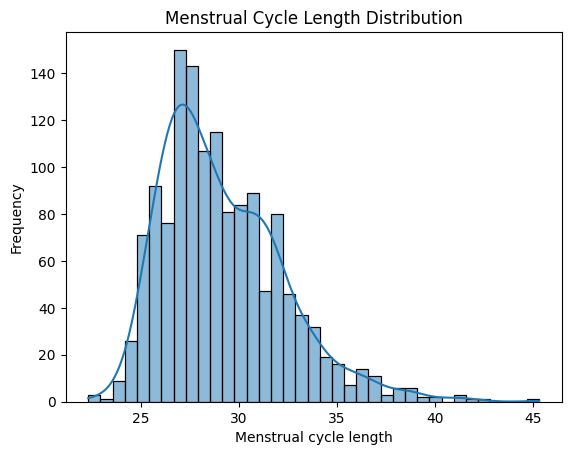

In [ ]:
sns.histplot(final_df["Mean_Length"], bins = 37, kde = True)
plt.xlabel("Menstrual cycle length") # change x-axis label
plt.ylabel("Frequency") # change y-axis label
plt.title("Menstrual Cycle Length Distribution") # change title
plt.show()

From the above plot, it appears as though "Mean_Cycle" has a right-skewed distribution, meaning that the majority of the data is located on the left side of the graph, and the mean is greater than the median.

In other words, most of the women in the sample have menstrual cycles that are on average shorter than longer. This makes sense given that the mean is 29.15 but there is a wide range of lengths found in the dataset, from 22.3 to 45.3 days.

## Demographic Variables

### BMI


Based on the results we found above, it appears as though women with higher BMIs tend to have longer menstrual cycles. This coincides with past research.

Let's plot the relationship between BMI and menstrual cycle length using a scatterplot with a OLS regression line to analyse it further.

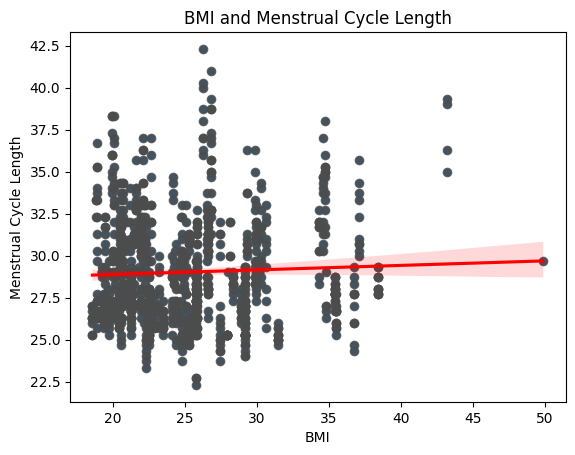

In [ ]:
sns.scatterplot(data = final_df, x = 'BMI',  y = 'Mean_Length')
sns.regplot(data = final_df, x = "BMI", y = "Mean_Length", color = ".3", line_kws=dict(color="r"))
plt.xlabel("BMI") # change x-axis label
plt.ylabel("Menstrual Cycle Length") # change y-axis label
plt.title("BMI and Menstrual Cycle Length") # change title
plt.show()

As the above scatterplot shows, women with higher BMIs do tend to have higher menstrual cycle lengths.

However, this relationship does not seem to be super significant given the slope of the regression line and the scattering of the points.


To further this analysis, let's look specifically at the different BMI categories we created and their relationship with menstrual cycle length.

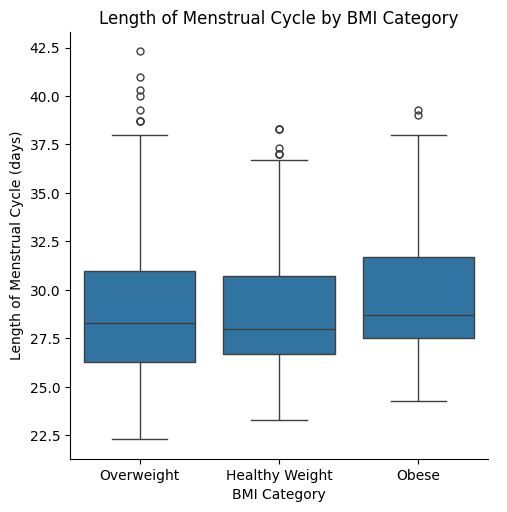

In [ ]:
# cause on the x-axis, outcome on the y-axis
sns.catplot(data = final_df, x = "BMI_Cat", y = "Mean_Length", kind = "box") # create box plot
# plt.xticks(rotation = 45) # rotate x-axis labels
plt.xlabel("BMI Category") # change x-axis label
plt.ylabel("Length of Menstrual Cycle (days)") # change y-axis label
plt.title("Length of Menstrual Cycle by BMI Category") # change title
plt.show()

The following can be interpreted from the above boxplot:

- Obese women have a longer median menstrual cycle than healthy weight and overweight women.
- Overweight women have the shortest minimum cycle length.
- Obese women have the longest. minimum cycle length.
- Healthy weight women have the longest maximum menstrual cycle length.
- Healthy weight women also have the most cycle length outliers of the BMI categories.
- The cycle length of Healthy Weight women and Obese women are positively skewed (skewed right).
    - This signifies that the bulk of the observations are at the low end (shorter menstrual cycles), with a few observations that are much larger (longer menstrual cycles) than the rest.
    - Their means are higher than their medians.
- The cycle lengt for Overweight women is relatively symmetrical.

With the skew of Healthy Weight and Obese women in mind, women with higher BMIs *do* tend to have higher menstrual cycle lengths, but this difference is likely not statistically significant given the skew of the data an the minimal differences in cycle lengths among the categories.

### Age

Let's also plot the relationship between Age and menstrual cycle length using a scatterplot with a OLS regression line to analyse it further.

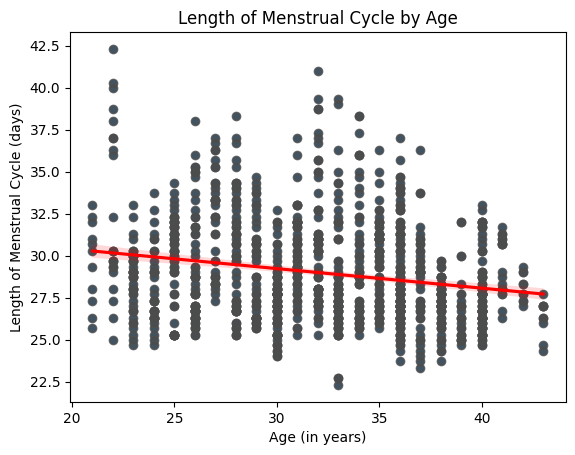

In [ ]:
sns.scatterplot(data = final_df, x = "Age", y = "Mean_Length")
sns.regplot(data = final_df, x = "Age", y = "Mean_Length", color = ".3", line_kws=dict(color="r"))
plt.xlabel("Age (in years)") # change x-axis label
plt.ylabel("Length of Menstrual Cycle (days)") # change y-axis label
plt.title("Length of Menstrual Cycle by Age") # change title
plt.show()

The above plot displays a very slight negative linear relationship (negative slope), indicating that as age increases, the length of one's menstrual cycle decreases.

Solely from appearance, this linear relationship appears to be slightly stronger than that found between BMI and cycle length.

This continues to bolster evidence that our dataset reflects previous research that older women tend to have shorter cycles than younger woman until the age of 50 years or older.



# Statistical analysis

### Correlation matrix

With seaborn's heatmap function, we can create a correlation matrix to see how the predictor variables BMI and Age relate to our main outcome variable Mean_Length.

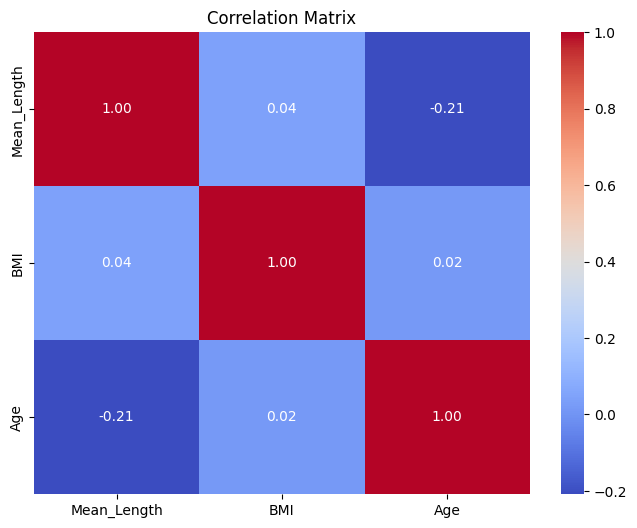

In [ ]:
# create correlation table between variables
corr = final_df[['Mean_Length', 'BMI', 'Age']].corr()

# plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

It appears that Age and Mean_Length have a correlation coefficient (r) of -0.21.

Additionally, BMI and Mean_Length have a correlation coefficient (r) of 0.04.

A "strong" r correlation coefficient is generally considered to be an absolute value of greater than 0.7, indicating a substantial linear relationship between two variables, where values closer to 1 or -1 represent a stronger correlation.

With that being said, neither Age or BMI have a statistically significant correlational relationship with Mean_Length.

Despite the fact that descriptive statistical analysis suggests a difference among the menstrual cycle lengths of women of different age and BMI scores, the above correlation matrix indicates that there are no significant relationships between these variables and our key outcome variable.  

# Random Forest Regressor

Since the variables in our dataset do not have a strong correlation with the target variable, traditional linear models like linear regression might not perform particularly well.

Thus, we will use a random forest regressor model as they are robust against noisy data, outliers, and missing values.

Since our target variable, (the length of) Cycle 3, is continuous, we will be using a random forest regressor model. This model will predict the average of the predictions of the trees using a training set that we will pull from the new_df DataFrame we created earlier.

Specifically, we will be taking the first two menstrual cycles of each row in new_df (Cycle 1 and Cycle 2) as predictor variables to model the values of the target variable, the length of Cycle 3.




Additionally, despite the fact that the above correlation matrix indicates that there is not a statistically significant relationship between Age and cycle length or BMI and cycle length, this does not necessarily mean that including these variables in our model would not increase its predictive ability.

The most effective way of testing this would be to construct two models: one with BMI and Age as secondary predictors alongside the main two (Cycle 1 and Cycle 2), and another model without, and then comparing the models to determine which has a better fit.

If the model with Age and BMI included has a lower RMSE and/or higher R-squared value, they will be included in the final model which will be used to predict the user's next cycle length. If not, or if the difference between the two models is negligible, then these predictors will be excluded.

Let's first start by initialising a global seed using the ```numpy``` and ```torch``` libraries to ensure that our model results are reproducible.

In [ ]:
def seed_everything(seed=42):
    """"
    Seed everything.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

## Model *with* demographic predictors

We will use ```train_test_split()``` to split final_df into a training set and test set.

Since our dataset is relatively small (1,382 samples), we will want to use a slightly larger test size to ensure that our test set has enough data for reliable evaluation. Thus, we will set the train_size parameter to 0.7 in order to extract 30% of the dataset for the testing set.



In [ ]:
seed_everything(42)

X = final_df[['Cycle_1', 'Cycle_2', 'Age', 'BMI']] # denote all predictos with uppercase X
y = final_df['Cycle_3'] # denote target (outcome variable) with lowercase Y

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = 42)
# test_size = 30% should go to the test set

In [ ]:
seed_everything(42)

model = RandomForestRegressor(random_state = 42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Testing model

Let us now calculate the difference between the actual target values in the testing set and the values predicted by the model with Root Mean Square Error (RMSE).

The RMSE determines the absolute fit of the model to the data and indicates how close the actual data points are to the model's predicted values.

Indeed, at this point we haven't actually made any predictions of the length of cycles that we don't already have data on. Instead, we had our model predict the lengths of Cycle 3 of each Client in the test set based on the lengths of Cycles 1 and 2 and are now *comparing* those predicted lengths to the *actual* Cycle 3 lengths in our dataset.

A *low* RMSE value indicates a better fitting model and is a good measure for determining the accuracy of the model's predictions.








In [ ]:
seed_everything(42)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

print(f"Random Forest - Train RMSE: {rmse_train:.2f}, Test RMSE: {rmse_test:.2f}")

Random Forest - Train RMSE: 1.58, Test RMSE: 3.34


Analysis of the RMSE values for both models will be conducted later when comparing the models to each other.

### R-squared

To further test the accuracy of our model, we can also calculate the **R-squared score**.

The R-squared value, ranging from 0 to 1, represents the proportion of the variance in the target variable that can be explained by the predictor variables in the model.

A low R-squared value suggests that the predictor variables in a regression model are not effictively explaining a large proportion of the variance in the outcome variable. A high R-squared value, on the other hand, suggests that the model fits the data well.


In [ ]:
seed_everything(42)

r2 = r2_score(y_test, y_pred_test)
print(f"R-squared: {r2:.4f}")

R-squared: 0.2050


## Model *without* demographic predictors

Now, let's create another model *without* Age and BMI included as predictors in order to compare the two models via cross-validation.



In [ ]:
seed_everything(42)

X_1 = final_df[['Cycle_1', 'Cycle_2']] # denote all predictos with uppercase X
y_1 = final_df['Cycle_3'] # denote target (outcome variable) with lowercase y

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, train_size=0.7, random_state = 42)
# test_size = 30% should go to the test set

In [ ]:
seed_everything(42)

model_small = RandomForestRegressor(random_state = 42)

model_small.fit(X_train_1, y_train_1)

RandomForestRegressor(random_state=42)

### Testing model

In [ ]:
seed_everything(42)

y_pred_train_small = model_small.predict(X_train_1)
y_pred_test_small = model_small.predict(X_test_1)

rmse_train_small = root_mean_squared_error(y_train_1, y_pred_train_small)
rmse_test_small = root_mean_squared_error(y_test_1, y_pred_test_small)

print(f"Random Forest - Train RMSE: {rmse_train_small:.2f}, Test RMSE: {rmse_test_small:.2f}")

Random Forest - Train RMSE: 2.51, Test RMSE: 3.39


### R-squared

In [ ]:
seed_everything(42)

r2_small = r2_score(y_test_1, y_pred_test_small)
print(f"R-squared: {r2_small:.4f}")

R-squared: 0.1797


## Comparing the models

Overall, we will determine which model is best using two metrics:

(1) compare the differences between the training RMSE and test RMSE of the two models, with the model with the least difference likely having better predictive power (and less issues with overfitting)

(2) compare only the test RMSEs of the two models and finding which model has the lowest RMSE value, and

(3) compare the R-squared values of the two models to find the model with the higher value.

Here is a summary of the two models' predictive ability:



In [ ]:
seed_everything(42)

print("Model *with* demographic predictors:\n")
print(f"Train RMSE: {rmse_train:.2f}\nTest RMSE: {rmse_test:.2f}")
print(f"R-squared: {r2:.2f}")
print("\n")
print("=======================")
print("\n")
print("Model *without* demographic predictors:\n")
print(f"Train RMSE: {rmse_train_small:.2f}\nTest RMSE: {rmse_test_small:.2f}")
print(f"R-squared: {r2_small:.2f}")

Model *with* demographic predictors:

Train RMSE: 1.58
Test RMSE: 3.34
R-squared: 0.21




Model *without* demographic predictors:

Train RMSE: 2.51
Test RMSE: 3.39
R-squared: 0.18


### Evaluating overfitting

As mentioned previously, in order to determine which model has the strongest predictive power, we will first start by comparing the differences between the training RMSE and test RMSE of the two models. The model with the smallest difference will indicate that it has a stronger fit and is also at less risk for overfitting.

When a model yields a small training RMSE but a very large test RMSE, we are said to be overfitting the data. The testing set RMSE will be very large because the supposed patterns that the model found in the training set does not exist in the testing set.

Let's first quickly calculate the differences between the testing and training RMSEs of both models.

In [ ]:
print(f"Difference for model WITH Age and BMI: {rmse_test - rmse_train:.2f}")
print(f"Difference for model WITHOUT Age and BMI: {rmse_test_small - rmse_train_small:.2f}")

Difference for model WITH Age and BMI: 1.76
Difference for model WITHOUT Age and BMI: 0.88


In [ ]:
1.36-0.54

0.8200000000000001

Regarding overfitting concerns, the differences for both models is not monumental enough to suggest that either model has overfitted the data. Their RMSE performances are similar enough that we can conclude that both models are well fit to their individual testing set.

However, the model *without* Age and BMI included, model_small, does have a slightly smaller difference, indicating that it may be a stronger model than the model with those variables included; however, further analysis is needed.

Let's continue comparing the models by looking only at their testing set RMSEs.

### Testing RMSEs

As another comparison metric, let's compare only the test RMSEs of the two models to find which model has the lowest RMSE value.

The model *without* Age and BMI included as predictors has a RMSE value of 3.11, indicating that the typical deviation between the predicted lengths of Cycle 3 and the actual lengths in the dataset is around 3.11 days off.

The model *with* Age and BMI, on the other hand, has a RMSE value of 2.98, indivating that this model predicted cycle lengths that were typically around 2.98 days off from the actual lengths.




However, we won't be able to determine whether these are low or high RMSE values unless we know the possible range of values that Cycle 3 has in our dataset. Thus, let's find the minimum and maximum values of Cycle 3.  

In [ ]:
print("The shortest possible length of Cycle 3 in the dataset is", final_df['Cycle_3'].min(), "days.")
print("The longest possible length of Cycle 3 in the dataset is", final_df['Cycle_3'].max(), "days.")

The shortest possible length of Cycle 3 in the dataset is 18.0 days.
The longest possible length of Cycle 3 in the dataset is 54.0 days.


Given that the length of Cycle 3 ranges a total of 36 days, it is clear then that a RMSE value of either 2.98 or 3.11 is low enough that we can conclude that both models have higher predictive power.

Additionally, although the differences in the RMSE values between the two models is almost negligible, it is clear that the model with Age and BMI included has slightly stronger predictive ability.

Specifically, the model with them included predicted Cycle 3 lengths that were approximately 0.13 days closer to the actual Cycle 3 lengths found in the dataset.

### R-squared

As a last measure to determine which model we should select for our predictive tool, let's compare the R-squared values of the two models to find the model with the higher value.

Model *with* secondary predictors:

R-squared: 0.28


=======================


Model *without* secondary predictors

R-squared: 0.21

The model *without* Age and BMI has a R-squared value of 0.21, meaning it explains approximately 21% of the variance in the length of Cycle 3.

Conversely, the model *with* them included, which has a value of 0.28, explaining 28% of the variance.

In summary, the provided output suggests that both models have a reasonably *poor* performance.

Indeed, despite the relatively promising results from when we calculated RMSE, these R-squared values indicate that our models does *not* fit the data well and has poor predictive power; essentially, the regression line does not closely represent actual data points.

Despite this, the model *with* the demographic predictors included explains slightly more of the variance in Cycle 3 length that the model *without* them included.

In conclusion, after comparing the testing and training RMSE's, the testing RMSE's only, and the R-squared values of the two models, it is clear that including the demographic variables Age and BMI in our model increases its predictive ability to a substantial enough degree to warrant including them in the final model we will use for the predictive menstrual cycle tool.


# Predictor Tool

Finally, we can create the predictor tool, which was the ultimate goal product of this analysis.

Let's first start by coding the inputs that the user will be asked to provide and assigning them to variables.

The users will be asked to provide the start date of their last **three** menstrual cycles, as three start dates are required in order to calculate *two* menstrual cycle lengths. As a reminder, the length of a menstrual cycle is defined as the time from the first day of a woman's period to the day before her next period.

Then, we will do some conversion of these variables to fit them into the model. I will convert the start dates of the two most recent cycles that the user provides to cycle lengths. Additionally, I will calculate BMI from the user's inputted height and weight, since the majority of people do not know their BMI off the top of their heads.

Lastly, I will port these user variables into the model to output a prediction.

In [ ]:
# ==================
# user input
# ==================
print("Welcome to my menstrual cycle predictor tool!")
name = input("What is your name?\n-> ")
print("Hello, " + name + "!")

# date_format = "%Y/%m/%d"
date_format = "%m/%d/%y"

# menstrual cycle dates
# -------------
# write function to validate dates
def validate_date(date_str): #validates if the input string is in datetime format "%m/%d/%Y".
    try:
        datetime.strptime(date_str, date_format)
    except ValueError:
        print("\nError: Incorrect date format. Please use mm/dd/yy.")
        return False
    return True

# ask for three recent period start dates
dates_list = input("\nPlease enter the start dates of your three most recent menstrual periods, separated by commas. \nPlease put the *most* recent date first and the *least* recent date last. \n(Enter dates as \"MM/DD/YY\")\n-> ").split(', ')

user_3, user_2, user_1 = dates_list

for date in dates_list:
    if validate_date(date):  # Pass each date string to the function
        pass
    else:
        print(f"\nDate {date} is invalid. Please re-enter the dates.")
        dates_list = input("\nPlease enter the start dates of your three most recent menstrual periods, separated by commas. \nPlease put the *most* recent date first and the *least* recent date last. \n(Enter dates as \"MM/DD/YY\")\n-> ").split(', ')

# age
# -------------
age = input("\nWhat is your age in years?\n-> ")

# height
# -------------
height = input("\nWhat is your height in feet and inches?\n-> ")

while True:
    try:
        feet, inches = map(int, height.split("'"))
        if feet < 0 or inches < 0 or inches > 11:
            raise ValueError
        break
    except ValueError:
        print("\nInvalid input. Please enter your height in the format 'feet'inches' (e.g., 5'7).")
        height = input("\nWhat is your height in feet and inches? ")

# weight
# -------------
weight = input("\nWhat is your weight in pounds? ")

# # ==================
# # conversion
# # ==================
# # convert cycle dates to datetime objects
# -------------
third_cycle = datetime.strptime(user_3, date_format)
second_cycle = datetime.strptime(user_2, date_format)
first_cycle = datetime.strptime(user_1, date_format)

# convert to cycle lengths
# -------------
user_cycle1 = (third_cycle - second_cycle)
user_cycle2 = (second_cycle - first_cycle)

# extract number of days as integer
# -------------
cycle_1 = user_cycle1.days
cycle_2 = user_cycle2.days

# convert user-inputted height in feet and inches to inches only
# -------------
def height_converter(height):
    feet, inches = map(int, height.split("'"))
    total_inches = (feet * 12) + inches
    return total_inches

# # create BMI variable from user-inputted height & weight
# # -------------
height_inches = height_converter(height)  # Convert height to total inches
weight_num = float(weight)  # Convert weight to a float

bmi = round((weight_num / (height_inches ** 2) * 703), 2)

# # ==================
# # port user inputs to model
# # ==================
# giving inputs to the machine learning model
features = [[cycle_1, cycle_2, int(age), bmi]]
features = np.array(features)

# using inputs to predict the output
prediction = model.predict(features)

# # convert prediction to integer
prediction = prediction[0].astype(float)

# # convert prediction from cycle length to next cycle start date
cycle_3 = third_cycle.date() + timedelta(days = prediction)

# # Format the datetime object to mm/dd/yyyy
predicted_date = cycle_3.strftime("%m/%d/%y")

print("\nThe predicted day that your next period will begin is: {}".format(predicted_date))
print("\n\nThank you for using my menstrual cycle predictor tool! Goodbye!\n")

Welcome to my menstrual cycle predictor tool!
What is your name?
-> Kai
Hello, Kai!

Please enter the start dates of your three most recent menstrual periods, separated by commas. 
Please put the *most* recent date first and the *least* recent date last. 
(Enter dates as "MM/DD/YY")
-> 11/30/24, 11/01/24, 09/18/24

What is your age in years?
-> 27

What is your height in feet and inches?
-> 5'11

What is your weight in pounds? 135

The predicted day that your next period will begin is: 01/03/25


Thank you for using my menstrual cycle predictor tool! Goodbye!



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


And there you have it, a menstrual cycle prediction tool using age and BMI as secondary predictor variables!

If you would like to test the model yourself, feel free to use the following inputs on the tool:

**Name:** Kai

**Dates:** 11/30/24, 11/01/24, 09/18/24

**Age**: 27

**Height**: 5'11

**Weight**: 135

From these inputs, the tool predicted that my next period would begin on 01/03/25. However, the output you get may be a bit different from mine considering that the tool is making a new prediction every time it is run!

# Saving files to Session Storage folder


## Create .zip folder

In [ ]:
# create new folder in Colab session storage
os.makedirs("final_project", exist_ok = True)

# FedCycleData071012.csv (original dataset)
# ----------
shutil.move("FedCycleData071012.csv", "final_project/") # move file into final_project folder
# / after folder name is required!!

# df
# ----------
# write dataset to storage in .csv format
df.to_csv("df.csv", index = False)
shutil.move("df.csv", "final_project/") # move file into final_project folder

# clean_df
# ----------
# write dataset to storage in .csv format
clean_df.to_csv("clean_df.csv", index = False)
shutil.move("clean_df.csv", "final_project/") # move file into final_project folder

# dems
# ----------
# write dataset to storage in .csv format
dems.to_csv("dems.csv", index = False)
shutil.move("dems.csv", "final_project/") # move file into final_project folder

# final_df
# ----------
# write dataset to storage in .csv format
final_df.to_csv("final_df.csv", index = False)
shutil.move("final_df.csv", "final_project/") # move file into final_project folder

'final_project/final_df.csv'

In [ ]:
# Final_Project.ipynb
# ----------
shutil.move("Final_Project.ipynb", "final_project/") # move file into final_project folder

'final_project/Final_Project.ipynb'

In [ ]:
!zip -r /content/final_project.zip /content/final_project

files.download("/content/final_project.zip")

  adding: content/final_project/ (stored 0%)
  adding: content/final_project/clean_df.csv (deflated 77%)
  adding: content/final_project/FedCycleData071012.csv (deflated 88%)
  adding: content/final_project/dems.csv (deflated 60%)
  adding: content/final_project/df.csv (deflated 88%)
  adding: content/final_project/final_df.csv (deflated 87%)
  adding: content/final_project/Final_Project.ipynb (deflated 63%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>